In [143]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import (
    train_test_split, 
    cross_val_score, 
    cross_val_predict,
    KFold)

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

from sklearn import metrics

## Load data

In [97]:
# load visual features
visual_features = pd.read_csv('../Py-Feat-main/video_features.csv', index_col=0)

# load labels
labels = pd.read_csv('../Py-Feat-main/labels.csv', index_col=0, delimiter=';')

# load speech to text features
audio_features = pd.read_csv('merged.csv')

In [98]:
audio_features

,VideoID,Sponsored,Sentiment,Transcription,Sentiment_RoBERTa,Probability
0,7215716180294683946,Yes,Postive,"The confidence boost, a glowy and dewy base g...",POSITIVE,0.998888
1,7210487841732840746,Yes,Positive,Watch how I create this glowing skin makeup b...,POSITIVE,0.998891
2,7218032675850849582,Yes,Positive,I get why this cream by Charlotte Tilbury is ...,POSITIVE,0.998886
3,7102205817524555054,Yes,Positive,Thanks for watching guys!,POSITIVE,0.998800
4,7220512664575986990,Yes,Positive,I love it. I love it more. I love it!,POSITIVE,0.998859
...,...,...,...,...,...,...
75,6990818542262226181,No,Positive,"I need no one. You're exciting boy, confining...",POSITIVE,0.997434
76,7166197472560254213,No,Positive,"You and I baby, who cares, I don't need to ca...",NEGATIVE,0.998331
77,7203417189737565446,No,Positive,Look at this. Oh! Perfect. Oh my God. Isn't i...,POSITIVE,0.998657
78,7098279023851097349,No,Neutral,"Okay, I need some assistance. Has any of you ...",NEGATIVE,0.993177


Merge the different feature sets with the corresponding labels

In [101]:
merged_df = (labels
             .reset_index()
             .merge(visual_features.reset_index(), 
                    left_on="VideoID", 
                    right_on="video_id")
             .drop(columns=["Sponsored", "Sentiment"])
             .merge(audio_features, 
                    on="VideoID")
             .drop(columns='VideoID')
             )

In [103]:
merged_df

,video_id,anger,disgust,fear,happy,neutral,sad,surprise,total_mean,negative_mean,Sponsored,Sentiment,Transcription,Sentiment_RoBERTa,Probability
0,7215716180294683946,0.010000,0.150000,0.170000,0.340000,0.770000,0.590000,0.330000,0.337143,0.230000,Yes,Postive,"The confidence boost, a glowy and dewy base g...",POSITIVE,0.998888
1,7210487841732840746,0.012195,0.658537,0.243902,0.085366,0.878049,0.219512,0.573171,0.381533,0.283537,Yes,Positive,Watch how I create this glowing skin makeup b...,POSITIVE,0.998891
2,7218032675850849582,0.035714,0.375000,0.178571,0.035714,0.785714,0.339286,0.678571,0.346939,0.232143,Yes,Positive,I get why this cream by Charlotte Tilbury is ...,POSITIVE,0.998886
3,7102205817524555054,0.025000,0.100000,0.175000,0.250000,0.575000,0.600000,0.125000,0.264286,0.225000,Yes,Positive,Thanks for watching guys!,POSITIVE,0.998800
4,7220512664575986990,0.000000,0.823529,0.235294,0.058824,0.882353,0.529412,0.294118,0.403361,0.397059,Yes,Positive,I love it. I love it more. I love it!,POSITIVE,0.998859
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,6990818542262226181,0.016807,0.840336,0.445378,0.084034,0.882353,0.386555,0.470588,0.446579,0.422269,No,Positive,"I need no one. You're exciting boy, confining...",POSITIVE,0.997434
76,7166197472560254213,0.094118,0.894118,0.223529,0.058824,0.929412,0.094118,0.235294,0.361345,0.326471,No,Positive,"You and I baby, who cares, I don't need to ca...",NEGATIVE,0.998331
77,7203417189737565446,0.000000,0.245283,0.264151,0.000000,0.396226,0.358491,0.396226,0.237197,0.216981,No,Positive,Look at this. Oh! Perfect. Oh my God. Isn't i...,POSITIVE,0.998657
78,7098279023851097349,0.000000,0.000000,0.106383,0.595745,0.361702,0.510638,0.255319,0.261398,0.154255,No,Neutral,"Okay, I need some assistance. Has any of you ...",NEGATIVE,0.993177


## Split data


In [104]:
# Load label
y = merged_df.Sentiment.replace({'Positive': 1, 'Postive': 1, 'Neutral': 0, 'Negative': 0})

# Load roBERTa labels
y_roberta = merged_df.Sentiment_RoBERTa.replace({'POSITIVE': 1, 'NEGATIVE': 0})

# load features
X = merged_df[['anger', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise', 'total_mean', 'negative_mean']]

### Rerun based on 5 different splits for cross validation

In [115]:
from sklearn.ensemble import RandomForestClassifier

In [116]:
# clf = SVC(kernel='rbf', random_state=24, gamma='scale', probability=True)
clf = RandomForestClassifier(max_depth=6, random_state=24)
cv = KFold(n_splits=5, random_state=24, shuffle=True)

# load predictions
y_pred = cross_val_predict(clf, X, y, cv=cv)
y_pred_prob_a = cross_val_predict(clf, X, y, cv=cv, method='predict_proba')

# print overal score
scores = cross_val_score(clf, X, y, cv=cv)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.71 accuracy with a standard deviation of 0.09


## Plot confusion matrices

### Confusion matrix for visual features

In [147]:
cm = metrics.confusion_matrix(y, y_pred)

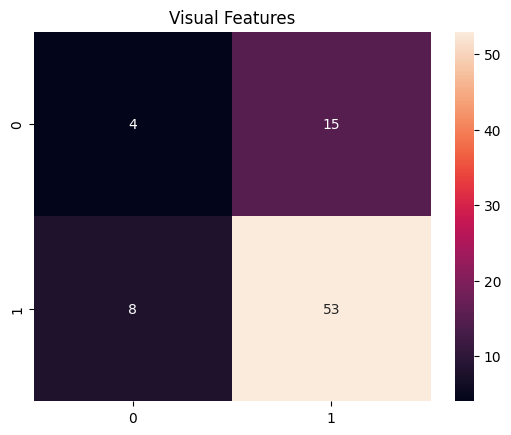

In [148]:
plt.title('Visual Features')
sns.heatmap(cm, annot=True)
plt.show()

### Confusion matrix for audio features

In [145]:
cm = metrics.confusion_matrix(y, y_roberta)

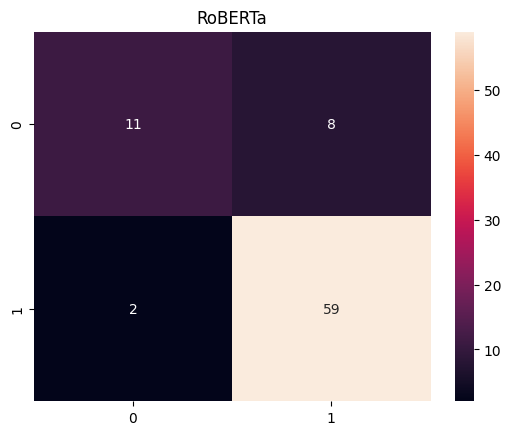

In [146]:
plt.title('RoBERTa')
sns.heatmap(cm, annot=True)
plt.show()

### Late fusion

In [140]:
pos = []
for x0, x1, y0, y1 in zip(y_pred, y_pred_prob_a, y_roberta, merged_df.Probability):
    
    if x0 == y0:
        pos.append(x0)
        
    else:
        # due to the high probability of roberta, roberta is most likely correct.
        # in case the random forest classifier is almost certain the sentiment is negative
        # choose for the decision of the random forest classifier
        if x1[0] >= .9:
            pos.append(x0)
        else:
            pos.append(y0)

In [141]:
cm = metrics.confusion_matrix(y, pos)

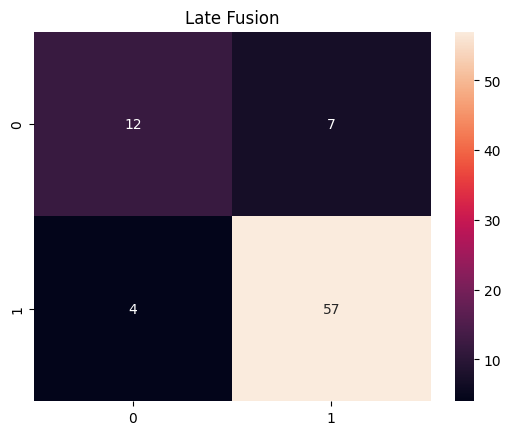

In [144]:
plt.title('Late Fusion')
sns.heatmap(cm, annot=True)
plt.show()